<a href="https://colab.research.google.com/github/ggronda/Stereotypical-Behaviour-Classification-for-mice/blob/main/DeepLabCut_Preprocessing_and_featuring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Comments

- Interpolation in lateral does not interpolate pawns because are never taken into account.



#Introduction

In this Jupyter notebook, we will use the ouput of a DeepLabCut proyect to analyze the behavior of mice in videos. Previously , we  created a project and label the body parts of the mice in a few frames. Then, we  trained a neural network to automatically track the body parts in the rest of the video. Finally, we will analyze the data to extract insights about the behavior of the mice.

#Loading the data and importing libraries.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import fnmatch
import cv2
import re
import random
import logging

# Set your project folder name and video type
ProjectFolderName = '/content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06'
VideoType = 'avi'

# Define the path to the main folder where you want to search
DATA_FOLDER = os.path.join(ProjectFolderName, "DATA_J")

# Initialize lists to store paths of top and lateral view videos
TOPVIDEOS_PATHS = []
LATERALVIDEOS_PATHS = []

# Search for top view videos and store their paths
for dirpath, dirs, files in os.walk(DATA_FOLDER):
    for filename in fnmatch.filter(files, '*after-inj-lateralJan7shuffle1_600000.h5'):
        LATERALVIDEOS_PATHS.append(os.path.join(dirpath, filename))

# Search for lateral view videos and store their paths
for dirpath, dirs, files in os.walk(DATA_FOLDER):
    for filename in fnmatch.filter(files, '*after_injJan5shuffle1_500000.h5'):
        TOPVIDEOS_PATHS.append(os.path.join(dirpath, filename))

# Check if the path exists
if not os.path.exists(TOPVIDEOS_PATHS[0]):
    print("The file's path doesn't exist.")

# Initialize lists to store data from top and lateral view videos
top_view_data = []
lateral_view_data = []

# Iterate through top view video paths and read data into DataFrames
for path in TOPVIDEOS_PATHS:
    top_view_data.append(pd.read_hdf(path, header=[1, 2, 3]))

# Iterate through lateral view video paths and read data into DataFrames
for path in LATERALVIDEOS_PATHS:
    lateral_view_data.append(pd.read_hdf(path, header=[1, 2, 3]))

# Get a list of unique headers from the top view data
header_list = list(set(list(top_view_data[0].columns.get_level_values(1))))

# Rename columns for top view data
for data in top_view_data:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

# Rename columns for lateral view data
for data in lateral_view_data:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

# Define coordinate header
coordinate_header = ["x", "y", "likelihood"]

# Initialize lists to store failed videos
failed_top_videos = []
failed_lateral_videos = []

TOPBOX=[[],[]] #Constant created in order to work with the box in the top view
TOPBOXCENTER=(0,0)



In [ ]:
top_view_data[0].head(2)


,Nosex,Nosey,Noselikelihood,Headx,Heady,Headlikelihood,Ear_leftx,Ear_lefty,Ear_leftlikelihood,Ear_rightx,...,Tail_1likelihood,Tail_2x,Tail_2y,Tail_2likelihood,Tail_3x,Tail_3y,Tail_3likelihood,Tail_4x,Tail_4y,Tail_4likelihood
0,102.277504,134.834656,0.000084,105.227448,141.209747,1.0,102.441887,151.888809,1.0,115.535942,...,1.0,152.206650,191.699982,1.0,169.152512,192.609543,0.99999,184.247620,188.688766,1.0
1,78.555244,108.967995,0.942181,77.579361,102.847939,1.0,87.820946,96.736626,1.0,75.558258,...,1.0,121.750526,76.303551,1.0,132.706512,92.237183,1.00000,143.043091,106.813034,1.0


# Auxiliary functions

## Function for saving and loading processed dataframes


In [ ]:
def save_dataframes_as_h5(dataframes, folder_path, view="top"):
    """
    Save a list of dataframes as HDF5 (.h5) files in a specified folder.

    Parameters:
    -----------
    dataframes : list of pandas.DataFrame
        A list of dataframes to be saved.
    folder_path : str
        The path to the folder where the HDF5 files will be saved.
    view : str, optional, default 'top'
        A prefix used for naming the saved HDF5 files.

    Returns:
    --------
    None

    Notes:
    ------
    This function creates the specified folder if it does not already exist.
    Each dataframe is saved in a separate HDF5 file, with file names indexed
    sequentially based on the given view prefix. To ensure consistent sorting,
    file names are generated with leading zeros (e.g., 'top001.h5', 'top002.h5', etc.).
    """

    # Ensure the folder exists; create it if not
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)

    # Save each dataframe to a separate HDF5 file with consistent file naming
    for idx, df in enumerate(dataframes):
        # Generate a unique file name with three-digit numbers (001, 002, 003, etc.)
        file_name = f"{view}{idx + 1:03d}.h5"  # ':03d' ensures three digits with leading zeros
        file_path = os.path.join(folder_path, file_name)

        # Save the dataframe to the HDF5 file with the specified key
        df.to_hdf(file_path, key='df', mode='w')

        print(f"Saved dataframe to: {file_path}")


def load_ordered_dataframes_from_h5(folder_path, view="top"):
    """
    Load all pandas dataframes from HDF5 (.h5) files in a specified folder in a consistent order.

    Parameters:
    -----------
    folder_path : str
        The path to the folder where the HDF5 files are stored.
    view : str, optional, default 'top'
        A prefix used to identify which HDF5 files to load.

    Returns:
    --------
    list of pandas.DataFrame
        A list containing the dataframes loaded from the HDF5 files, sorted by file name.

    Notes:
    ------
    This function loads all HDF5 files in the specified folder that have the ".h5" extension
    and start with the specified view prefix. Files are sorted by name to ensure a consistent
    order of retrieval. It assumes that each HDF5 file contains a dataframe stored under the
    key 'df', which should be the same key used when saving.

    If the folder does not exist, a `FileNotFoundError` is raised.
    """

    import os
    import pandas as pd

    # Ensure the folder exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    # Get a sorted list of all relevant HDF5 files in the folder
    h5_files = sorted([f for f in os.listdir(folder_path) if f.endswith(".h5") and f.startswith(view)])

    dataframes = []  # List to store the loaded dataframes

    # Load each dataframe from its corresponding HDF5 file
    for file_name in h5_files:
        file_path = os.path.join(folder_path, file_name)

        # Read the dataframe from the HDF5 file
        df = pd.read_hdf(file_path, key='df')
        dataframes.append(df)

        print(f"Loaded dataframe from: {file_path}")

    return dataframes



##Function for collect video paths

In [ ]:

def get_avi_filenames(h5_paths):
    """
    Get the paths of corresponding .avi files for a list of .h5 file paths.

    Parameters:
    h5_paths (list of str): List of paths to .h5 files.

    Returns:
    list of str: List of paths to corresponding .avi files. If no .avi file is found or if there are multiple .avi files in a folder, None is appended to the list.
    """
    # Initialize an empty list to store .avi file paths
    avi_paths = []

    # Iterate through each .h5 file path in the input list
    for h5_path in h5_paths:
        # Get the folder containing the .h5 file
        folder_path = os.path.dirname(h5_path)

        # List all files in the folder
        files = os.listdir(folder_path)

        # Filter files with .avi extension
        avi_files = [file for file in files if file.endswith('.avi')]

        # Check the number of .avi files found
        if len(avi_files) == 1:
            # If there is exactly one .avi file, append its path to the list
            avi_paths.append(os.path.join(folder_path, avi_files[0]))
        else:
            # If there are no .avi files or more than one, append None to the list
            avi_paths.append(None)

    # Return the list of .avi file paths
    return avi_paths





##Preprocessing functions

In [ ]:
def df_invert_y(dataframes):
    """
    Inverts the values in columns whose headers contain 'y' for each DataFrame in the list.
    Note: This functions is made only for the lateral view data.
    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames to invert.
    """
    for df in dataframes:
        # Invert values in columns containing 'y'
        for column in df.columns:
            if 'y' in column:
                # Multiply by -1 to invert values and add 240
                # Explanation: Invert y-values and add 240 to adjust to a new coordinate system
                df[column] *= -1
                df[column] += 240

def np_likelihoodFilter(x, y, lik, value):
    """
    Filter points based on likelihood values greater than a given threshold.

    Parameters:
    x (numpy.ndarray): Array of x-coordinates.
    y (numpy.ndarray): Array of y-coordinates.
    lik (numpy.ndarray): Array of likelihood values.
    value (float): Threshold value for likelihood.

    Returns:
    tuple: A tuple containing filtered x-coordinates, y-coordinates, and likelihood values.
    """
    # Generating boolean array indicating whether likelihood values are greater than the threshold
    filtered_indexes = [val > value for val in lik]

    # Filtering x coordinates based on the boolean array
    x_filtered = np.where(filtered_indexes, x, np.nan)

    # Filtering y coordinates based on the boolean array
    y_filtered = np.where(filtered_indexes, y, np.nan)

    # Filtering likelihood values based on the boolean array
    lik_filtered = np.where(filtered_indexes, lik, np.nan)

    if np.isnan(lik_filtered).all():
      return x,y,lik

    return x_filtered, y_filtered, lik_filtered


def df_likelihoodFilter(dataframes):
    """
    Filter all the dataframes by likelihood.

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames to invert.
    """
    # Iterate through each DataFrame in the list
    for animal in dataframes:
        # Iterate through each label in the header list
        for label_1 in header_list:
            # Extract x, y points, and corresponding likelihood for the current label
            x_points = np.array(animal[label_1 + coordinate_header[0]])
            y_points = np.array(animal[label_1 + coordinate_header[1]])
            likel = np.array(animal[label_1 + coordinate_header[2]])

            # Filter points based on likelihood using barelikelihoodFilter function
            x_points, y_points, lik = np_likelihoodFilter(x_points, y_points, likel, 0.95)

            # Update the DataFrame with filtered x, y, and likelihood values
            animal[label_1 + coordinate_header[0]] = x_points
            animal[label_1 + coordinate_header[1]] = y_points
            animal[label_1 + coordinate_header[2]] = lik
    return dataframes

def np_interpolate_nan(x, y):
    """
    Interpolate NaN values in x and y arrays.

    Parameters:
    x (numpy.ndarray): Array of x-coordinates.
    y (numpy.ndarray): Array of y-coordinates.

    Returns:
    tuple: A tuple containing interpolated x-coordinates and y-coordinates.
    """
    nan_indices = np.isnan(x)
    if np.any(nan_indices):
            x[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), x[~nan_indices])
            y[nan_indices] = np.interp(np.flatnonzero(nan_indices), np.flatnonzero(~nan_indices), y[~nan_indices])
    return x, y

def df_interpolate_nan(dataframes):
    """
    Filter all the dataframes by likelihood and interpolate NaN values.

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames to filter.
    """
    popped = 0
    # Iterate through each DataFrame in the list
    for index,animal in enumerate(dataframes):
        # Iterate through each label in the header list
        for label_1 in header_list:
            # Extract x, y points, and corresponding likelihood for the current label
            x_points = np.array(animal[label_1 + coordinate_header[0]])
            y_points = np.array(animal[label_1 + coordinate_header[1]])

            try:
              # Filter points based on likelihood and interpolate NaN values
              x_points, y_points = np_interpolate_nan(x_points, y_points)
            except:
              print("Error interpolating " + str(label_1) + " in video of index", index+popped)
              popped+=1
              dataframes.pop(index)
              break

            # Update the DataFrame with filtered x, y values
            animal[label_1 + coordinate_header[0]] = x_points
            animal[label_1 + coordinate_header[1]] = y_points
    return dataframes

def np_rotatePointsClockwise(x, y, center_x, center_y):
    """
    Rotate the given points clockwise by 90 degrees around the specified center.

    Parameters:
    x (list): List of x-coordinates of the points.
    y (list): List of y-coordinates of the points.
    center_x (float): x-coordinate of the center of rotation.
    center_y (float): y-coordinate of the center of rotation.

    Returns:
    tuple: A tuple containing the rotated x-coordinates and rotated y-coordinates.
    """
    # Calculate the differences in x and y from the center
    delta_x = [x_i - center_x for x_i in x]
    delta_y = [y_i - center_y for y_i in y]

    # Apply the 90-degree clockwise rotation
    rotated_dx = delta_y
    rotated_dy = [-x_i for x_i in delta_x]

    # Calculate the absolute coordinates of the rotated points
    rotated_x = [x_i + center_x for x_i in rotated_dx]
    rotated_y = [y_i + center_y for y_i in rotated_dy]

    return rotated_x, rotated_y  # Return the rotated coordinates as a tuple

def df_rotatePointsClockwise(dataframes, center_x, center_y):
    """
    Rotate the points in each DataFrame clockwise by 90 degrees around the specified center.

    Parameters:
    dataframes (list of pd.DataFrame): List of DataFrames containing points to be rotated.
    center_x (float): x-coordinate of the center of rotation.
    center_y (float): y-coordinate of the center of rotation.

    Returns:
    None
    """
    # Iterate through each DataFrame in the list
    for df in dataframes:
        # Iterate through each label in the header list
        for label_1 in header_list:
            # Extract x, y points for the current label
            x_points = np.array(df[label_1 + coordinate_header[0]])
            y_points = np.array(df[label_1 + coordinate_header[1]])

            # Rotate points clockwise by 90 degrees around the specified center
            rotated_x, rotated_y = np_rotatePointsClockwise(x_points, y_points, center_x, center_y)

            # Update the DataFrame with rotated x and y coordinates
            df[label_1 + coordinate_header[0]] = rotated_x
            df[label_1 + coordinate_header[1]] = rotated_y

    return dataframes




##Auxiliary box functions

In [ ]:
def boxCenterCalculator(x_1, y_1, x_n, y_n):
    """
    Calculate the center point of a box given its diagonal coordinates.

    Parameters:
    x_1 (float): x-coordinate of the first diagonal point.
    y_1 (float): y-coordinate of the first diagonal point.
    x_n (float): x-coordinate of the second diagonal point.
    y_n (float): y-coordinate of the second diagonal point.

    Modify:
    TOPBOXCENTER: A tuple containing the x-coordinate and y-coordinate of the center point.
    """
    # Calculate the x-coordinate of the center point
    return ((x_1 + x_n) / 2, (y_1 + y_n) / 2)


def boxPlot(show_trajectory=False):
    """
    Plot a box and a set of points on a matplotlib plot.

    This function assumes that the variables TOPBOX, TOPBOXCENTER, and A are defined elsewhere in the code.

    Parameters:
    show_trajectory (bool, optional): Whether to show the trajectory. Default is False.

    Returns:
    None
    """
    # Plot the box defined by TOPBOX

    plt.plot(TOPBOX[0], TOPBOX[1], color="r", linewidth=1)

    # Plot the TOPBOXCENTER
    plt.plot(TOPBOXCENTER[0], TOPBOXCENTER[1], "ro", markersize=1)

    # If show_trajectory is True, plot the trajectory for each animal in top_view_data
    if show_trajectory:
        plt.title("Box + Head trayectories")
        for animal in top_view_data:
            plt.plot(animal["Headx"], animal["Heady"], alpha=0.3, linewidth=0.1)



def topboxLimitsCalculator(data_list, show=False):
    """
    Compute the minimum and maximum bounds of densely populated areas based on the provided data.

    Parameters:
    data_list (list): A list of dictionaries containing coordinates and likelihoods of nose, right ear, and left ear.
    show (bool, optional): Whether to show the heatmap. Default is False.

    Returns:
    tuple: A tuple containing the minimum and maximum bounds of x and y coordinates.
    """
    total_x = []
    total_y = []

    # Iterate through each animal in top_view_data
    for df in data_list:
        for column in df.columns:
              # Check if the column contains x-coordinates
              if 'x' in column:
                  # Extend the total_x list with the x-coordinates
                  total_x.extend(df[column])
              # Check if the column contains y-coordinates
              if 'y' in column:
                  # Extend the total_y list with the y-coordinates
                  total_y.extend(df[column])

    # Plot a hexbin heatmap of the head coordinates if show is True
    if show:
        # Create a hexbin plot with the x and y coordinates
        plt.hexbin(total_x, total_y, gridsize=60, cmap='inferno', edgecolors='none')
        # Add a colorbar to the plot
        plt.colorbar(label='Density of points')
        # Add X label to the plot
        plt.xlabel('X')
        # Add Y label to the plot
        plt.ylabel('Y')
        # Add title to the plot
        plt.title('Thresholded Heatmap of trayectories ')
        # Show the plot
        plt.show()

    # Compute 2D histogram
    counts, xedges, yedges = np.histogram2d(total_x, total_y, bins=300)

    # Find densely populated areas
    indices_densos = np.where(counts >= 1000)
    x_densos = (xedges[indices_densos[0]] + xedges[indices_densos[0] + 1]) / 2
    y_densos = (yedges[indices_densos[1]] + yedges[indices_densos[1] + 1]) / 2

    # Compute minimum and maximum bounds
    a = min(x_densos)
    c = max(x_densos)
    b = min(y_densos)
    d = max(y_densos)

    # Define box vertices
    x_box = [a, c, c, a, a]
    y_box = [d, d, b, b, d]

    # Extend TOPBOX with box vertices
    TOPBOX[0].extend(x_box)
    TOPBOX[1].extend(y_box)

    # Print box error
    print("Box error", abs(c + b - a - d))

    # Calculate and store the center point of the box
    TOPBOXCENTER = boxCenterCalculator(a, b, c, d)
    return TOPBOXCENTER


##Mouse visualization functions

In [ ]:
def show_mouse(ini, fin, animal, show_box=True):
    """
    Visualizes the data of a mouse including its spine, head, and neck from an initial index to a final index.

    Parameters:
        ini (int): Initial index of the frame from which to start visualizing the data.
        fin (int): Final index of the frame up to which to visualize the data.
        animal (DataFrame): DataFrame containing the data of the mouse.
        show_box (bool, optional): Whether to plot the box. Default is True.

    Returns:
        None

    Note:
        The 'animal' DataFrame is expected to contain columns representing the coordinates of the mouse's body parts.
        - The spine should have the following columns: Nose, Head, Neck, Back_1, Back_2, Back_3, Back_4, Tail_1, Tail_2, Tail_3, Tail_4.
        - The head should have the following columns: Ear_left, Ear_right, Nose.
        - The neck should have the following columns: Ear_left, Ear_right, Neck.

    If 'show_box' is set to True, the function will also plot the box.
    Note that the box plot should not be done in lateral view data.
    """
    spine = ["Nose", "Head", "Neck", "Back_1", "Back_2", "Back_3", "Back_4", "Tail_1", "Tail_2", "Tail_3", "Tail_4"]
    head = ["Ear_left", "Ear_right", "Nose", "Ear_left"]
    neck = ["Ear_left", "Ear_right", "Neck", "Ear_left"]
    body = ["Ear_left", "Ear_right", "Tail_1", "Ear_left"]
    for index, df in animal.iterrows():
        if ini <= index <= fin:
            spine_list_x = []
            spine_list_y = []
            head_list_x = []
            head_list_y = []
            neck_list_x = []
            neck_list_y = []
            body_list_x = []
            body_list_y = []

            # Extract x and y coordinates for spine, head, and neck from the DataFrame
            for label in spine:
                spine_list_x.append(df[label + "x"])
                spine_list_y.append(df[label + "y"])
            for label in head:
                head_list_x.append(df[label + "x"])
                head_list_y.append(df[label + "y"])
            head_list_x.append(head_list_x[0])
            head_list_y.append(head_list_y[0])
            for label in neck:
                neck_list_x.append(df[label + "x"])
                neck_list_y.append(df[label + "y"])
            neck_list_x.append(neck_list_x[0])
            neck_list_y.append(neck_list_y[0])
            for label in body:
                body_list_x.append(df[label + "x"])
                body_list_y.append(df[label + "y"])
            body_list_x.append(body_list_x[0])
            body_list_y.append(body_list_y[0])

            plt.title("Mouse triangulation:")
            # Plot lines and points
            plt.plot(spine_list_x, spine_list_y, linestyle='--', alpha=0.5, color="r")
            plt.scatter(spine_list_x, spine_list_y, color="r", s=5)  # Points on the spine column line

            plt.plot(head_list_x, head_list_y, linestyle='--', alpha=0.5, color="g")
            plt.scatter(head_list_x, head_list_y, color="g", s=5)  # Points on the head column line
            plt.fill(head_list_x, head_list_y, color="g", alpha=0.1)

            plt.plot(neck_list_x, neck_list_y, linestyle='--', alpha=0.5, color="b")
            plt.scatter(neck_list_x, neck_list_y, color="b", s=5)  # Points on the neck column line

            plt.plot(body_list_x, body_list_y, linestyle='--', alpha=0.5, color="m")
            plt.scatter(body_list_x, body_list_y, color="m", s=5)  # Points on the neck column line
            plt.fill(body_list_x, body_list_y, color="m", alpha=0.1)

        elif index >= fin:
            break
        else:
            continue

    # Automatically adjust the scale and display the plot
    if show_box:
        boxPlot()

    plt.autoscale()
    plt.show()


##Functions for working with angles

In [ ]:
def calculate_direction(vector1, vector2):
    """
    Calculates the direction between two points.

    Args:
        point1 (tuple): Coordinates of the first point (x1, y1). Origin point.
        point2 (tuple): Coordinates of the second point (x2, y2). Destination point.

    Returns:
        float: Direction in radians.
    """
    # Convert points to numpy arrays
    p1 = np.array(vector1)
    p2 = np.array(vector2)

    # Calculate the direction vector
    direction_vector = p1 - p2

    # Calculate the direction angle (in radians)
    direction_angle = np.arctan2(direction_vector[1], direction_vector[0])

    # Ensure the angle is within the range [0, 2*pi)
    angle = (direction_angle + (2 * np.pi)) % (2 * np.pi)

    return angle

def plot_unit_circle():
    """
    Plots the unit circle centered at the origin for visualizing angles.

    This function provides a simple visualization of angles using a unit circle.

    Returns:
        None
    """
    # Generate theta values from 0 to 2*pi
    theta = np.linspace(0, 2*np.pi, 100)

    # Calculate x and y coordinates using trigonometric functions
    x = np.cos(theta)
    y = np.sin(theta)

    # Plot the unit circle using gray dashed lines
    plt.plot(x, y, color='gray', linestyle='--')

def circular_distance(angle1, angle2):
    """
    Computes the clockwise circular angular distance between two angles.

    This function calculates the angular difference in the clockwise direction between two given angles
    in radians, considering the circular nature of angles.

    Parameters:
        angle1 (float): The first angle in radians.
        angle2 (float): The second angle in radians.

    Returns:
        float: The clockwise circular angular distance between the two angles.
    """
    angle_difference = angle1 - angle2

    if angle_difference < 0:
        angle_difference += 2 * np.pi

    return angle_difference


def show_mouse_angle(frame, video, vista=""):
    """
    Visualizes the mouse's body orientation and angles on a unit circle for a specific frame of a video in top view.

    This function calculates the angles between the nose-neck and neck-back of a mouse at a given frame
    and visualizes them on a unit circle plot along with the difference angle.

    Parameters:
        frame (int): The frame index for which to visualize the angles.
        video (int): The index of the video from which to extract the data.
        vista (str, optional): Specifies the view mode. If "lateral", shows lateral view. Otherwise, shows top view. Default is "".

    Returns:
        None
    """
    # Extracting coordinates for nose and neck points
    point1 = (top_view_data[video]["Nosex"][frame], top_view_data[video]["Nosey"][frame])
    point2 = (top_view_data[video]["Neckx"][frame], top_view_data[video]["Necky"][frame])

    # Calculating direction angles
    angle1 = calculate_direction(point1, point2)

    # Extracting coordinates for back and neck points
    point3 = (top_view_data[video]["Back_1x"][frame], top_view_data[video]["Back_1y"][frame])

    # Calculating direction angles
    angle2 = calculate_direction(point3, point2)

    # Calculating circular distance between angles
    angle3 = circular_distance(angle1, angle2)

    # Showing mouse orientation
    if vista == "lateral":
        show_mouse(frame, frame, lateral_view_data[video])
    else:
        show_mouse(frame, frame, top_view_data[video])

    # Plotting
    plt.figure(figsize=(6, 6))
    plot_unit_circle()  # Plotting unit circle
    plt.quiver(0, 0, np.cos(angle1), np.sin(angle1), angles='xy', scale_units='xy', scale=1, color='blue',
               label='Head Vector')  # Plot direction arrow
    plt.quiver(0, 0, np.cos(angle2), np.sin(angle2), angles='xy', scale_units='xy', scale=1, color='red',
               label='Body-to-tail Vector')  # Plot direction arrow
    #plt.quiver(0, 0, np.cos(angle3), np.sin(angle3), angles='xy', scale_units='xy', scale=1, color='green',
    #           label='Angle diff')  # Plot direction arrow
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Direction on Unit Circle')
    plt.grid(True)
    plt.legend(loc='upper right')  # Add legend
    plt.show()  # Show plot



def add_orientationangle_to_dataframes(dataframes):
    """
    Add neck torsion angle information to a list of DataFrames.

    Parameters:
        dataframes (list of DataFrame): List of DataFrames containing mouse data.

    Returns:
        list of DataFrame: List of updated DataFrames with neck torsion angle information.
    """
    updated_dataframes = []  # List to store updated DataFrames
    for animal in dataframes:  # Iterate over each DataFrame in the list
        angles = np.array([])  # List to store neck torsion angles for each row
        for index, df in animal.iterrows():  # Iterate over each row in the DataFrame
            nose = (df["Nosex"], df["Nosey"])  # Coordinates of the nose
            neck = (df["Neckx"], df["Necky"])  # Coordinates of the neck
            back = (df["Back_1x"], df["Back_1y"])  # Coordinates of the back
            # Calculate direction from nose to neck and from back to neck
            angle1 = calculate_direction(nose, neck)
            angle2 = calculate_direction(back, neck)
            # Calculate the neck torsion angle
            angle3 = circular_distance(angle1, angle2)
            angles = np.append(angles, angle3)  # Append neck torsion angle to the list

        # Calculate the angular velocity
        angles_diff = np.diff(angles)
        angles_diff = np.append(angles_diff, angles_diff[-1])  # Duplicate the last value

        # Calculate the change in orientation


        # Add the columns to the DataFrame
        animal["Orientation_angle"] = angles
        animal["Orientation_angle_velocity"] = angles_diff

        angles -= np.pi
        sign_changes = np.sign(angles_diff)
        orientation_change = (sign_changes != np.roll(sign_changes,1)).astype(int)

        animal["Orientation_change"] = orientation_change

        updated_dataframes.append(animal)  # Append the updated DataFrame to the list

    return updated_dataframes  # Return the list of updated DataFrames



##Body curvature functions

We define the body curvature as the area of a polygon created using the backpoints. The area problem is calculated with the following formula:

The **Shoelace formula** is a method for calculating the area of a polygon defined by its vertices. Given a polygon with vertices defined by their Cartesian coordinates $(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)$, the formula computes the area using the following steps:

1. **Multiply Coordinates:**
   For each vertex $i$ from 1 to $n$, multiply the $x$-coordinate of vertex $i$ by the $y$-coordinate of the next vertex $i+1$ (or $1$ if $i = n$), and subtract the $y$-coordinate of vertex $i$ multiplied by the $x$-coordinate of the next vertex $i+1$ (or $x_1$ if $i = n$)).
   
   This can be expressed as:
   $$ A = \frac{1}{2} \left| \sum_{i=1}^{n} (x_i y_{i+1} - y_i x_{i+1}) \right| $$

2. **Summation:**
   Sum up all these products computed in step 1.

3. **Final Calculation:**
   Finally, take the absolute value of the sum obtained in step 2 and divide it by $2$ to get the area of the polygon.

The Shoelace formula derives its name from the way the vertices' coordinates are multiplied and subtracted, resembling the lacing pattern of a shoelace.

The provided Python function `shoelace_area(x, y)` implements this formula, taking as input two lists, `x` and `y`, containing the $x$-coordinates and $y$-coordinates of the polygon vertices respectively. The function then returns the computed area of the polygon.


In [ ]:
from sklearn.linear_model import LinearRegression

def shoelace_area(x, y):
    """
    Calculates the area of a polygon defined by its vertices using the shoelace formula.

    Parameters:
        x (list): List of x-coordinates of the polygon vertices.
        y (list): List of y-coordinates of the polygon vertices.

    Returns:
        float: Area of the polygon.
    """
    n = len(x)
    area = 0.0

    # Apply the shoelace formula
    for i in range(n):
        j = (i + 1) % n
        area += x[i] * y[j]
        area -= y[i] * x[j]
    area = abs(area) / 2.0  # Take absolute value and halve the result

    return area


def addBodyCurvature(animal):
    """
    Add curvature information to the DataFrame for each frame.

    Parameters:
        animal (DataFrame): DataFrame containing the data of the mouse.

    Returns:
        DataFrame: Updated DataFrame with added curvature information.
    """
    points = ["Nose", "Head", "Neck", "Tail_1"]
    back = ["Back_1", "Back_2", "Back_3", "Back_4"]

    for index, df in animal.iterrows():
        back_x = []
        back_y = []
        x_coordinates = []
        y_coordinates = []
        limit_p_x = [df["Neckx"], df["Tail_1x"]]
        limit_p_x = np.array(limit_p_x).reshape(-1, 1)

        # Extract x and y coordinates for points and back from the DataFrame
        for label in points:
            x_coordinates.append(df[label + "x"])
            y_coordinates.append(df[label + "y"])

        for label in back:
            back_x.append(df[label + "x"])
            back_y.append(df[label + "y"])

        x = np.array(x_coordinates).reshape(-1, 1)
        y = np.array(y_coordinates)

        # Fit linear regression model
        modelo = LinearRegression()
        modelo.fit(x, y)
        y_values = modelo.predict(limit_p_x)

        # Add additional points for back curvature calculation
        back_x.insert(0, float(limit_p_x[0]))  # Avoid deprecation of casting
        back_y.insert(0, float(y_values[0]))
        back_x.append(float(limit_p_x[1]))
        back_y.append(float(y_values[1]))
        back_x.append(back_x[0])
        back_y.append(back_y[0])

        # Calculate area (curvature) using shoelace formula
        area = shoelace_area(back_x, back_y)

        # Update DataFrame with curvature information
        animal.at[index, "Curvature"] = area

    return animal


def add_curvature_to_dataframes(dataframes):
    """
    Add curvature information to a list of DataFrames.

    Parameters:
        dataframes (list of DataFrame): List of DataFrames containing mouse data.

    Returns:
        list of DataFrame: List of updated DataFrames with curvature information.
    """
    for df in dataframes:
        df = addBodyCurvature(df)  # Apply addBodyCurvature to each DataFrame
    return dataframes

## Auxiliary functions to find extreme values

In [ ]:
def percentile_calculator(column_values, alpha=None):
    """
    Calculate percentiles and identify indices outside the range.

    Parameters:
        column_values (array-like): Array-like object containing the values of a DataFrame column.
        alpha (int, optional): Value to determine the percentile. Default is None.

    Returns:
        tuple: A tuple containing a list of indices where the values fall outside the specified range,
         the lower percentile value and the top percentile value.
    """
    # Set default percentiles
    percentiles = [97.5, 2.5]

    # Check if custom alpha is provided
    if alpha is not None:
        percentiles = [100 - alpha, alpha]

    # Convert column values to numpy array
    arr = np.array(column_values)

    # Create histogram
    hist, bins = np.histogram(arr, bins=20)  # Adjust the number of bins as needed

    # Plot histogram
    plt.hist(arr, bins=bins, density=True)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.grid(True)
    plt.show()

    # Calculate maximum and minimum values based on percentiles
    top_percentile, low_percentile = np.percentile(arr, percentiles)

    # Identify indices of values outside the specified range
    outliers_index = [index for index, value in enumerate(arr) if not low_percentile <= value <= top_percentile]

    return outliers_index, low_percentile, top_percentile

def quick_histogram(array, num_bins):
    """
    Quickly plot a histogram for a given array of data.

    Parameters:
        array (array-like): Array-like object containing the data for the histogram.
        num_bins (int): Number of bins to use in the histogram.

    Returns:
        None
    """
    plt.hist(array, bins=num_bins,density=True, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
    plt.ylabel('Frequency')
    plt.title('Histogram')
    plt.grid(True)
    plt.show()


##Height in lateral view data

In [ ]:
def add_Height_difference_to_dataframes(dataframes):
    """
    Add a new column with the difference between the height in the top and lower body.
    Note: This function is only mean to be used with lateral view data

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames to invert.
    """
    # Define the list of columns representing the bottom and top body parts
    bottomy = [ "Back_3y", "Back_4y", "Tail_1y"]
    topy = ["Ear_lefty", "Ear_righty", "Nosey",  "Heady","Necky"]

    # Iterate through each DataFrame in the list
    for animal in dataframes:
        # Calculate the mean values of top and bottom body parts along the rows
        top_mean_valuesy = np.mean(animal[topy], axis=1)
        bottom_mean_valuesy = np.mean(animal[bottomy], axis=1)

        # Calculate the difference in height between top and bottom body parts
        Height_difference = top_mean_valuesy - bottom_mean_valuesy

        # Add the height difference as a new column to the DataFrame
        animal["Height_difference"] = Height_difference
    return dataframes


##Auxiliary functions made by Gonzalo

In [ ]:
def info_from_path(video_path) -> dict():
    # Extract Mouse number, date, and video type from the path using regular expressions
    match = re.search(r'Mouse(\d+)_([\d-]+)_.*?beh-(CROP|CROP1)\.avi', video_path)
    if match:
        mouse_number = match.group(1)
        date = match.group(2)
        video_format = 'Top' if match.group(3) == 'CROP' else 'Lateral'
        info_dict = {
            'MouseNumber': mouse_number,
            'Date': date,
            'VideoFormat': video_format
        }
        return info_dict

def get_frame(video_path, frame):
  # Open the video file
  cap = cv2.VideoCapture(video_path)

  # Set the frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame)

  # Read the frame at the specified time
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  return frame


##########################################
#Functions made using Gonzalo's as a base#
##########################################
def show_frames(frame,video):
    # Create a matplotlib figure with number of columns equal to the number of frames
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        frame0 = get_frame(TOPVIDEOS_PATHS[video], frame)
        frame1 = get_frame(LATERALVIDEOS_PATHS[video], frame)

        # Convert the frame from BGR to RGB (matplotlib expects RGB)
        frame_rgb0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2RGB)
        frame_rgb1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)

        # Plot the frame on the corresponding subplot
        axs[0].imshow(frame_rgb0)
        axs[0].axis('off')  # Turn off the axis
        axs[1].imshow(frame_rgb1)
        axs[1].axis('off')  # Turn off the axis

        plt.show()

##Functions for body velocity and acceleration

In [ ]:

def add_velocity_to_dataframes(dataframes):
    """
    Add a new column with the velocity of the body movement in x and y directions,
    and also the total velocity of the body movement.

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames containing lateral view data.

    Returns:
    - list of pd.DataFrame: List of DataFrames with the added velocity columns.
    """
    if not all(isinstance(df, pd.DataFrame) for df in dataframes):
        raise ValueError("All elements in 'dataframes' should be pandas DataFrames.")

    # Define the list of columns representing the bottom and top body parts
    body_y = ["Back_1y", "Back_2y", "Back_3y", "Back_4y", "Tail_1y"]
    body_x = ["Back_1x", "Back_2x", "Back_3x", "Back_4x", "Tail_1x"]

    # Iterate through each DataFrame in the list
    for animal in dataframes:
        # Calculate the mean values of top and bottom body parts along the rows
        mean_body_y = np.mean(animal[body_y], axis=1)
        mean_body_x = np.mean(animal[body_x], axis=1)

        # Calculate the difference in height between top and bottom body parts
        body_y_diff = np.diff(mean_body_y)

        body_x_diff = np.diff(mean_body_x)


        # Calculate total velocity
        total_velocity = np.sqrt(body_x_diff ** 2 + body_y_diff ** 2)


        body_y_diff = np.append(body_y_diff, body_y_diff[-1])  # Duplicate the last value
        body_x_diff = np.append(body_x_diff, body_x_diff[-1])  # Duplicate the last value
        total_velocity = np.append(total_velocity,0)
        # Add the velocities as new columns to the DataFrame
        animal["Body_Velocity_x"] = body_x_diff
        animal["Body_Velocity_y"] = body_y_diff
        animal["Body_Velocity"] = total_velocity

    return dataframes


def add_acceleration_to_dataframes(dataframes):
    """
    Add a new column with the acceleration of the body movement in x and y directions.


    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames containing lateral view data.

    Returns:
    - list of pd.DataFrame: List of DataFrames with the added acceleration columns.
    """
    if not all(isinstance(df, pd.DataFrame) for df in dataframes):
        raise ValueError("All elements in 'dataframes' should be pandas DataFrames.")

    # Iterate through each DataFrame in the list
    for animal in dataframes:
        # Convert velocity columns to numpy arrays
        body_y = np.array(animal["Body_Velocity_y"])
        body_x = np.array(animal["Body_Velocity_x"])
        body = np.array(animal["Body_Velocity"])

        # Calculate the difference in velocity between consecutive time steps
        body_y_diff = np.diff(body_y)
        body_y_diff = np.append(body_y_diff, body_y_diff[-1])  # Duplicate the last value
        body_y_diff = np.abs(body_y_diff)  # Take absolute values
        body_x_diff = np.diff(body_x)
        body_x_diff = np.append(body_x_diff, body_x_diff[-1])  # Duplicate the last value
        body_x_diff = np.abs(body_x_diff)  # Take absolute values
        body_diff = np.diff(body)
        body_diff = np.append(body_diff, body_diff[-1])  # Duplicate the last value
        body_diff = np.abs(body_diff)  # Take absolute values

        # Add the acceleration as new columns to the DataFrame
        animal["Body_acceleration_x"] = body_x_diff
        animal["Body_acceleration_y"] = body_y_diff
        animal["Body_acceleration"] = body_diff


    return dataframes

def add_distance_to_dataframes(dataframes):
    """
    Add a new column with the accumulated distance traveled by the body movement.

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames containing lateral view data.

    Returns:
    - list of pd.DataFrame: List of DataFrames with the added distance column.
    """
    if not all(isinstance(df, pd.DataFrame) for df in dataframes):
        raise ValueError("All elements in 'dataframes' should be pandas DataFrames.")

    # Iterate through each DataFrame in the list
    for animal in dataframes:
        # Get the velocity in pixels per frame
        body_velocity = np.array(animal["Body_Velocity"])

        # Initialize the accumulated distance column with zeros
        accumulated_distance = np.zeros(len(body_velocity))

        # Calculate the accumulated distance at each point
        for i in range(1, len(body_velocity)):
            # Calculate the distance traveled in this frame (velocity * time)
            distance_traveled = body_velocity[i]  # Assuming time interval between frames is 1 (you may need to adjust this)

            # Add the distance traveled to the accumulated distance
            accumulated_distance[i] = accumulated_distance[i - 1] + distance_traveled

        # Add the accumulated distance as a new column to the DataFrame
        animal["Accumulated_Distance"] = accumulated_distance

    return dataframes



##Body angles upgrade

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression

def body_angle(dataframe):
    """
    Function to calculate the body angle based on coordinates of specific body parts.

    Args:
        dataframe (DataFrame): Input DataFrame containing coordinates of body parts.

    Returns:
        DataFrame: DataFrame with added "Body_Angle" column.
    """
    # Define lists of body parts for the top and bottom of the body
    bottom = ["Back_3", "Back_4", "Tail_1","Neck","Back_2", "Back_1"]
    top = ["Nose", "Head", "Neck"]

    # Iterate over rows in the DataFrame
    angles = []
    for index, df in dataframe.iterrows():
        bottom_x = []
        bottom_y = []
        top_x = []
        top_y = []

        # Extract x and y coordinates for points at the top and bottom of the body
        for label in top:
            top_x.append(df[label + "x"])
            top_y.append(df[label + "y"])

        for label in bottom:
            bottom_x.append(df[label + "x"])
            bottom_y.append(df[label + "y"])

        # Fit linear regression models for top and bottom points
        modelo_top = LinearRegression()
        modelo_bottom = LinearRegression()
        modelo_top.fit(np.array(top_x).reshape(-1, 1), np.array(top_y))
        modelo_bottom.fit(np.array(bottom_x).reshape(-1, 1), np.array(bottom_y))

        # Inference 1: Using Nose and Neck for top points
        nose_top = (df["Nosex"], modelo_top.predict([[df["Nosex"]]])[0])
        neck_top = (df["Neckx"], modelo_top.predict([[df["Neckx"]]])[0])

        # Inference 2: Using Tail_1 and Neck for bottom points
        tail1_bottom = (df["Tail_1x"], modelo_bottom.predict([[df["Tail_1x"]]])[0])
        neck_bottom = (df["Neckx"], modelo_bottom.predict([[df["Neckx"]]])[0])

        # Calculate the direction angles between the inferred points
        angle1 = calculate_direction(nose_top, neck_top)
        angle2 = calculate_direction(tail1_bottom, neck_bottom)

        # Calculate the circular distance between the angles
        angle3 = circular_distance(angle1, angle2)

        angles.append(angle3)

    dataframe["Body_Angle"] = np.array(angles)
    return dataframe

def add_body_angle_to_dataframes_upgrade(Dataframes):
    """
    Function to add body angle calculation to multiple DataFrames.

    Args:
        Dataframes (list): List of DataFrames containing coordinates of body parts.

    Returns:
        list: List of DataFrames with "Body_Angle" column added.
    """
    # Iterate over each DataFrame
    for df in Dataframes:
        df = body_angle(df)
    return Dataframes
def show_mouse_angle_upgrade(frame, video, vista=""):
    """
    Visualizes the mouse's body orientation and angles on a unit circle for a specific frame of a video in top view.

    This function calculates the angles between the nose-neck and neck-back of a mouse at a given frame
    and visualizes them on a unit circle plot along with the difference angle.

    Parameters:
        frame (int): The frame index for which to visualize the angles.
        video (int): The index of the video from which to extract the data.
        vista (str, optional): Specifies the view mode. If "lateral", shows lateral view. Otherwise, shows top view. Default is "".

    Returns:
        None
    """
    bottom = ["Back_3", "Back_4", "Tail_1","Neck","Back_2", "Back_1"]
    top = [ "Nose", "Head", "Neck"]
    df = top_view_data[video].iloc[frame]

    bottom_x = []
    bottom_y = []
    top_x = []
    top_y = []

    # Extract x and y coordinates for points at the top and bottom of the body
    for label in top:
        top_x.append(df[label + "x"])
        top_y.append(df[label + "y"])

    for label in bottom:
        bottom_x.append(df[label + "x"])
        bottom_y.append(df[label + "y"])

    # Fit linear regression models for top and bottom points
    modelo_top = LinearRegression()
    modelo_bottom = LinearRegression()
    modelo_top.fit(np.array(top_x).reshape(-1, 1), np.array(top_y))
    modelo_bottom.fit(np.array(bottom_x).reshape(-1, 1), np.array(bottom_y))

    # Inference 1: Using Nose and Neck for top points
    nose_top = (df["Nosex"], modelo_top.predict([[df["Nosex"]]])[0])
    neck_top = (df["Neckx"], modelo_top.predict([[df["Neckx"]]])[0])

    # Inference 2: Using Tail_1 and Neck for bottom points
    tail1_bottom = (df["Tail_1x"], modelo_bottom.predict([[df["Tail_1x"]]])[0])
    neck_bottom = (df["Neckx"], modelo_bottom.predict([[df["Neckx"]]])[0])

    # Calculate the direction angles between the inferred points
    angle1 = calculate_direction(nose_top, neck_top)
    angle2 = calculate_direction(tail1_bottom, neck_bottom)

    # Calculate the circular distance between the angles
    angle3 = circular_distance(angle1, angle2)

    # Showing mouse orientation
    if vista == "lateral":
        show_mouse(frame, frame, lateral_view_data[video])
    else:
        show_mouse(frame, frame, top_view_data[video])

    # Plotting
    plt.figure(figsize=(6, 6))
    plot_unit_circle()  # Plotting unit circle
    plt.quiver(0, 0, np.cos(angle1), np.sin(angle1), angles='xy', scale_units='xy', scale=1, color='blue',
               label='Head Vector')  # Plot direction arrow
    plt.quiver(0, 0, np.cos(angle2), np.sin(angle2), angles='xy', scale_units='xy', scale=1, color='red',
               label='Body-to-tail Vector')  # Plot direction arrow
    #plt.quiver(0, 0, np.cos(angle3), np.sin(angle3), angles='xy', scale_units='xy', scale=1, color='green',
    #           label='Angle diff')  # Plot direction arrow
    plt.gca().set_aspect('equal', adjustable='box')  # Set equal aspect ratio
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Direction on Unit Circle')
    plt.grid(True)
    plt.legend(loc='upper right')  # Add legend
    plt.show()  # Show plot



## Plotting trayectories


In [ ]:
def plot_trajectory(position, column_name, labeled=""):
    """
    Plots the trajectory for a given position and column_name from two dataframes.

    Parameters:
        position (int): The position in the dataframes.
        column_name (str): The name of the column in the dataframes.
        labeled (str, optional): Additional label for the plot title (default is an empty string).
    """
    # Extract data from the specified dataframes
    x_top = top_view_data[position][column_name + 'x']
    y_top = top_view_data[position][column_name + 'y']

    x_lateral = lateral_view_data[position][column_name + 'x']
    y_lateral = lateral_view_data[position][column_name + 'y']

    # Create the plot
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Set the size of the plot with two subplots

    # Plot for top view data
    axs[0].plot(x_top, y_top)
    axs[0].set_title('Top View Trajectory')
    axs[0].set_xlabel(column_name + 'x')
    axs[0].set_ylabel(column_name + 'y')
    axs[0].grid(True)

    # Plot for lateral view data
    axs[1].plot(x_lateral, y_lateral)
    axs[1].set_title('Lateral View Trajectory')
    axs[1].set_xlabel(column_name + 'x')
    axs[1].set_ylabel(column_name + 'y')
    axs[1].grid(True)

    # Show the legend
    axs[0].legend()
    axs[1].legend()

    # Add a title
    plt.suptitle(labeled + " " + column_name + ' Trajectory', fontsize=16)

    # Show the plot
    plt.show()


#Preprocessing the data

This initial step ensures we have a backup of the original data before any processing or analysis begins and let us "undo" changes in a quick way if needed.

In [ ]:

LATERALVIDEOS_PATHS = get_avi_filenames(LATERALVIDEOS_PATHS)
TOPVIDEOS_PATHS = get_avi_filenames(TOPVIDEOS_PATHS)
MOUSE_DATA=[]
for path in TOPVIDEOS_PATHS:
   dic = info_from_path(str(path))
   MOUSE_DATA.append(dic)



Let's visualize an example of the trayectories

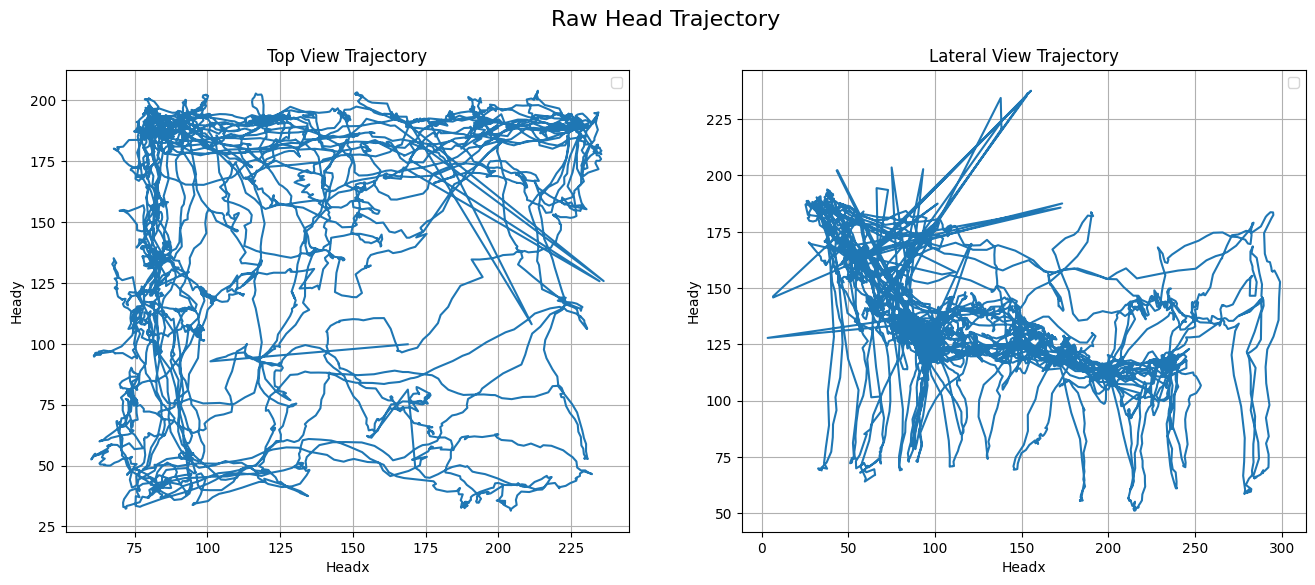

In [ ]:
plot_trajectory(5,"Head","Raw")

DeepLabCut outputs confidence scores alongside the detected keypoints, often referred to as likelihoods. These scores indicate the model's certainty in its predictions. Here, we filter the data to retain only keypoints with a likelihood greater than or equal to a predefined threshold of 0.95 (as defined in the auxiliary functions section). This ensures we focus on detections where the model is highly confident, improving the reliability of our analysis.

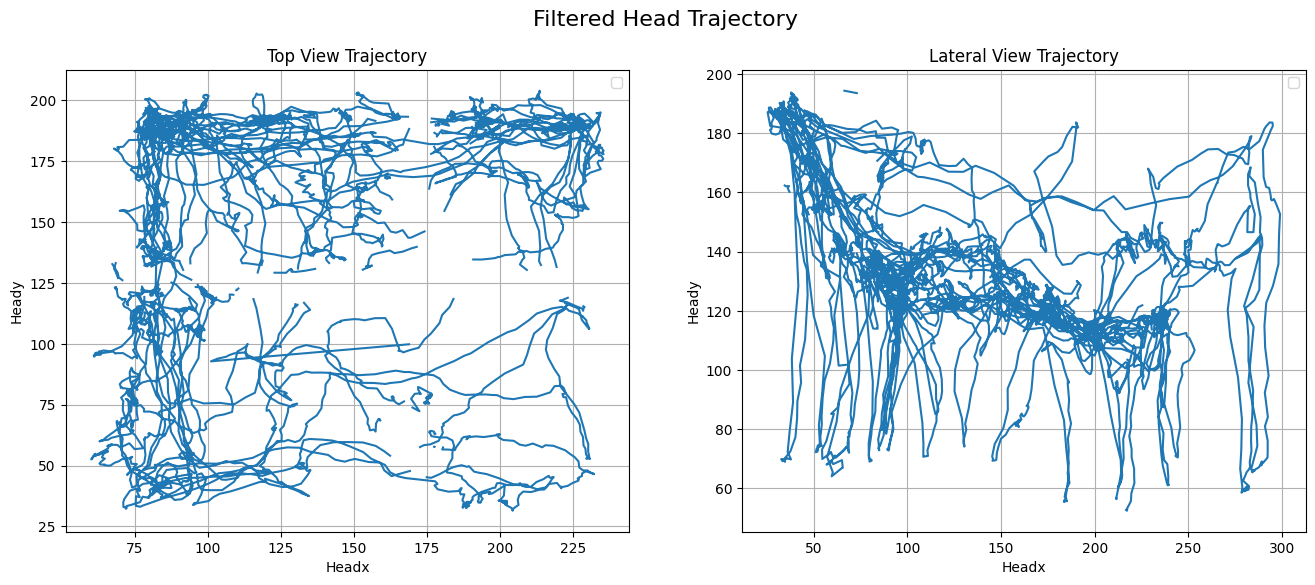

In [ ]:
top_view_data = df_likelihoodFilter(top_view_data)
lateral_view_data = df_likelihoodFilter(lateral_view_data)
plot_trajectory(5,"Head","Filtered")

We interpolate the data to achieve smoother trajectories. Videos with interpolation issues are excluded for separate analysis.

In [ ]:
top_view_data = df_interpolate_nan(top_view_data)
lateral_view_data = df_interpolate_nan(lateral_view_data)
#plot_trajectory(5,"Head","Interpolated")

DeepLabCut  presents the y-coordinates in a way that reflects a horizontal mirror image. In other words, the y-coordinates are flipped. To rectify this, we  invert the  sign of y-coordinates and add 240 to correct it to positive values.

In [ ]:
df_invert_y(lateral_view_data)
df_invert_y(top_view_data)

##Rotating top view data

DeepLabCut  present the  data for top view videos rotated 90 degrees counter-clockwise. Here's how we address this:

- Find Box Center: We calculate the center point of the mouse's box.

- Rotate Keypoints: All keypoints are rotated 90° clockwise around this center point, effectively undoing the unintended rotation.


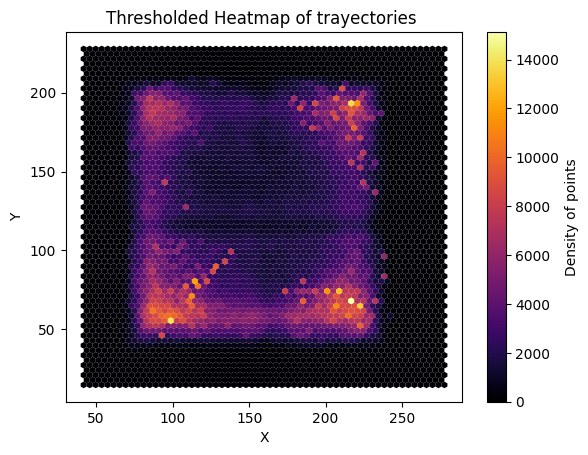

Box error 0.46677241007489556


In [ ]:
TOPBOXCENTER = topboxLimitsCalculator(top_view_data,show=True)

Before correcting the top view rotation, let's visualize the data to understand its initial state

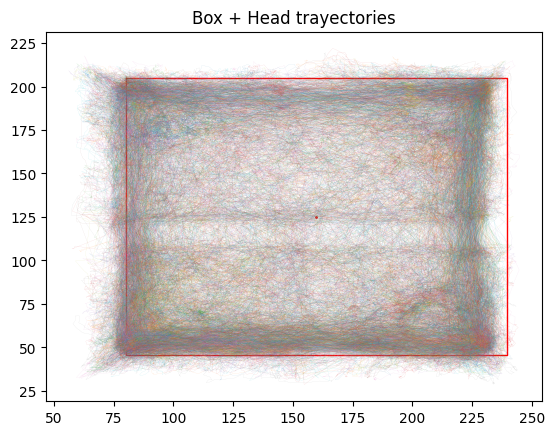

In [ ]:
boxPlot(show_trajectory=True)

Now we proceed to rotate the data and  recalculate the box's limits and center

In [ ]:
top_view_data = df_rotatePointsClockwise(top_view_data,TOPBOXCENTER[0],TOPBOXCENTER[1])

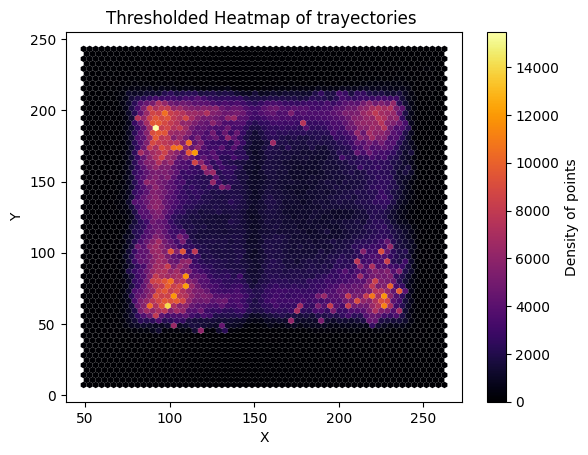

Box error 0.46677241007486714


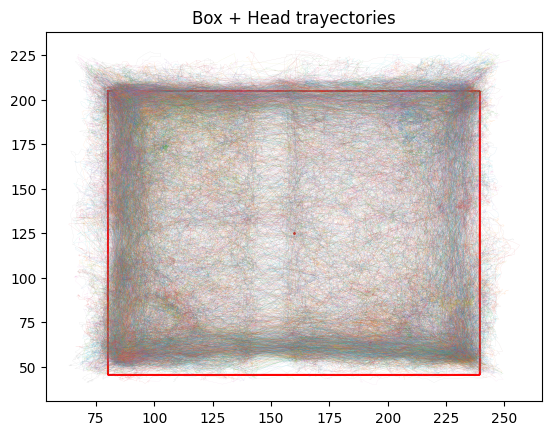

In [ ]:
TOPBOXCENTER = topboxLimitsCalculator(top_view_data,show=True)
boxPlot(show_trajectory=True)

Thus we have just finished data preprocessing




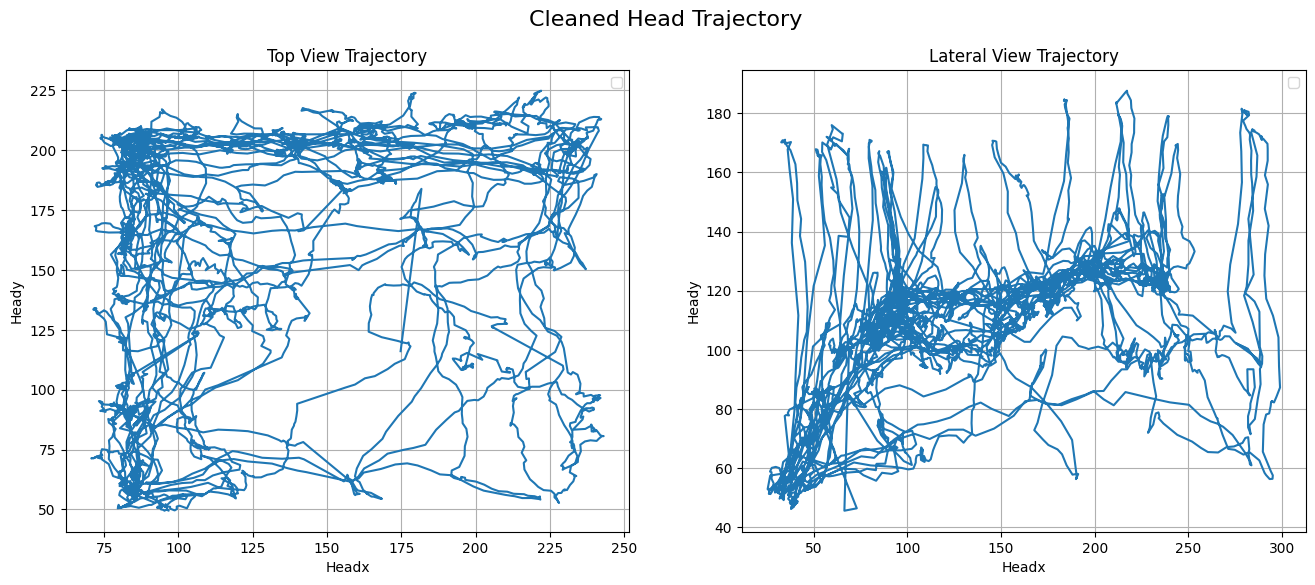

In [ ]:
plot_trajectory(5,"Head","Cleaned")

#Data mining

## Visualization

Before diving into data mining, let's take a moment to visualize how we'll represent the mice in our analysis. Here's an example plot showcasing a single mouse at a specific frame within a video:

In [ ]:
frame = 500
video = 0
minitop = top_view_data[:2]
minilateral=lateral_view_data[:2]

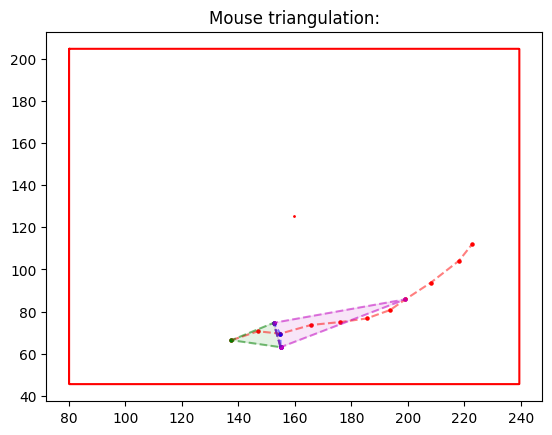

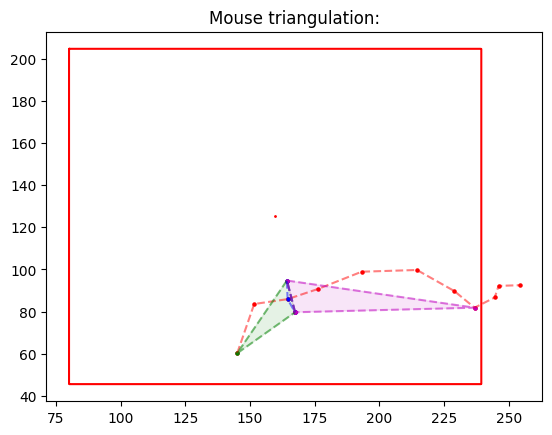

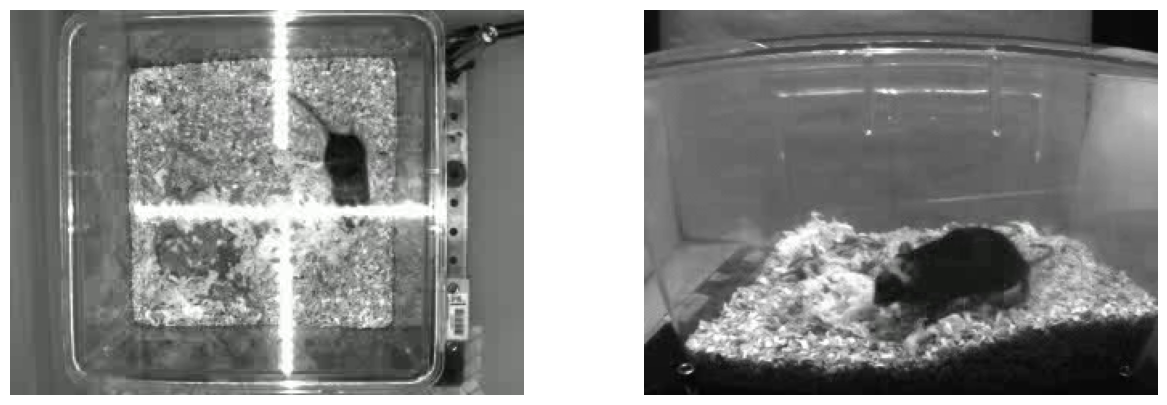

In [ ]:
show_mouse(frame,frame,top_view_data[video])
show_mouse(frame,frame,lateral_view_data[video])
show_frames(frame,video)

##Orientation in top view

We can gain insights into a mouse's neck orientation (looking left, right, or straight) by analyzing the angles between keypoints. Here's the approach:

Vector Definition: We defined two vectors originating from the neck point:


  -   Neck-to-Nose Vector: This vector points from the neck base towards the nose keypoint.
  -   Neck-to-Body Part Vector: This vector points from the neck base towards the first labeled body part.

Angle Calculation: We calculate the angle between these two vectors at each frame. This angle reflects the relative position of the nose and body part with respect to the neck.

Orientation Interpretation:

  - Near 180° Angle: This indicates the mouse is looking straight ahead, as the neck-to-nose and neck-to-body part vectors are aligned.
  - Angle < 180°: This suggests the mouse is looking to the right. A smaller angle signifies a sharper turn towards the right.
  - Angle > 180°: This indicates the mouse is looking to the left. Angles exceeding 180° by larger values represent sharper turns to the left.

We add a column that indicates if the mouse changed directions between frames, with 1 indicating a change and 0 indicating no change.





Now we are going to add a new column named "Body_Angle" to our data.



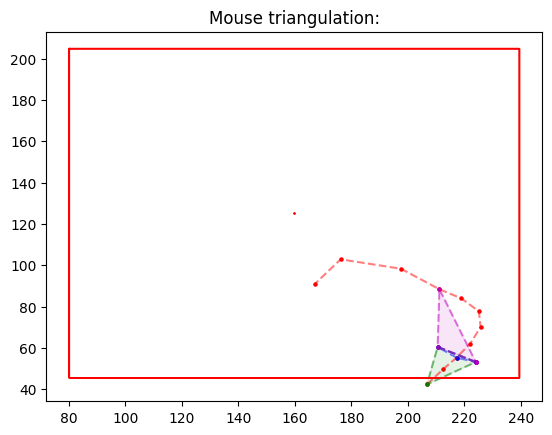

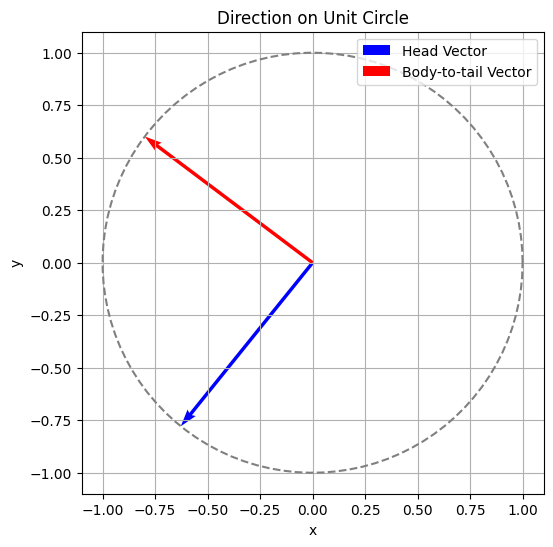

In [ ]:
#show_mouse_angle(frame,video)
show_mouse_angle_upgrade(50,3)

In [ ]:
#top_view_data=add_orientationangle_to_dataframes(top_view_data)
top_view_data=add_body_angle_to_dataframes_upgrade(top_view_data)

##Body curvature


We define body curvature  as the area of a polygon formed by:
  - The union of back points.
  - Two points inferred at the neck and tail base.
A linear regression is performed on head and tail base points to establish a baseline body orientation.

Need to update:

- Frequent linear regression and polygons area calculations for each frame is computationally expensive taking into account our data is about 6000frames*80 videos
- There is a deprecation in casting, that`s why we ignore the warnings

In [ ]:
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
lateral_view_data=add_curvature_to_dataframes(lateral_view_data)
warnings.filterwarnings("default", category=DeprecationWarning)

Our method does not work with triangles

##Velocity, acceleration and distance


- Velocity Calculation:

To calculate the velocity, we compute the average position of specific body points over time and determine the rate of change of these positions. By measuring the displacement per unit time, we obtain the velocity of the mouse at each frame(pixels per frame). This provides insights into the speed of movement exhibited by the mice throughout the experiment.

- Acceleration Calculation:

Acceleration, on the other hand, represents the rate of change of velocity. In this analysis, we compute acceleration in absolute terms, disregarding direction, to understand how quickly the mice are accelerating or decelerating at different points during their trajectories. This metric helps in identifying sudden changes or fluctuations in movement patterns, which may be indicative of certain behaviors or responses.

- Distance Calculation:
As the velocity is calculated as pixels per frame it is the acumulated velocity.




In [ ]:
top_view_data = add_velocity_to_dataframes(top_view_data)
#lateral_view_data = add_velocity_to_dataframes(lateral_view_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_view_data = add_acceleration_to_dataframes(top_view_data)
#lateral_view_data = add_acceleration_to_dataframes(lateral_view_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The same but for a smaller copy to do some test

## Calculating Height Difference between Top and Lower Body in Lateral View


The lateral view provides a side-on perspective of the mouse trajectory, allowing us to capture vertical movements more accurately. By focusing on this view, we ensure that the calculated height difference reflects changes in the mouse's posture along the vertical axis.
- We calculate the vertical displacement by computing the difference in the y-coordinates (height) between the middle points of the head and lower back. This gives us a measure of the height difference between the top and lower body segments at each frame.








In [ ]:
lateral_view_data = add_Height_difference_to_dataframes(lateral_view_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Saving and loading dataframes


##Saving


In [ ]:
DATAFRAMES_FOLDER = os.path.join(ProjectFolderName, "DATAFRAMES")
save_dataframes_as_h5(top_view_data,DATAFRAMES_FOLDER)
save_dataframes_as_h5(lateral_view_data,DATAFRAMES_FOLDER,"lateral")

Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top001.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top002.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top003.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top004.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top005.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top006.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classification /SBC-Jesus-2024-02-06/DATAFRAMES/top007.h5
Saved dataframe to: /content/gdrive/MyDrive/Cajal/Stereotypical Behavior Classifica

##Loading


In [ ]:
# DATAFRAMES_FOLDER = os.path.join(ProjectFolderName, "DATAFRAMES")
# top_view_data=load_ordered_dataframes_from_h5(DATAFRAMES_FOLDER)
# lateral_view_data=load_ordered_dataframes_from_h5(DATAFRAMES_FOLDER,"lateral")

CONTINUE IN ANOTHER COLLAB